## Import modules and define functions

In [1]:
import glob
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error


def hampel_filter_static(landsat, insitu, n_sigmas): 
    deviation = landsat - insitu
    median = deviation.median()
    mad = np.median(np.abs(deviation - median))
    threshold = n_sigmas * mad
    outlier_idx = np.abs(deviation - median) > threshold
    landsat[outlier_idx] = np.nan  # Optionally replace outliers with median: series[outlier_idx] = median
    return landsat

def calculate_median_error(constant, df_sensor):
    adjusted_sst = df_sensor['landsat_SST'] + constant[0]
    return np.median(np.abs(adjusted_sst - df_sensor['insitu_SST']))


# File processing

Loading and pre-processing landsat validation data from google drive

In [2]:
script_dir = os.getcwd() # Get the current working directory
data_dir = os.path.join(script_dir, 'data', 'Landsat_validation')

file_list = glob.glob(os.path.join(data_dir, '**', '*.csv'), recursive=True)

print('No. of files before filtering:', len(file_list))
# REMOVING CTD CASTS: 
file_list = [file for file in file_list if not file.endswith("CT.csv")]
print('No. of files after filtering:', len(file_list))
print('PROCESSED WITHOUT CTD CASTS')

data = []
failed_files = 0

for file in file_list:
    try:
        df = pd.read_csv(file).dropna(subset=['TEMP', 'SST'])
        df[['lon', 'lat']] = df['.geo'].str.extract(r'\[([^,]+),\s*([-\d.]+)\]') # Extracting lon and lat from .geo column
        # retrieve last two letters of the file name
        df['OBS_ID'] = os.path.basename(file).split('_')[-1].split('.')[0]
        df['Landsat'] = df['LANDSAT_ID'].str.extract(r'(\d+)') # Extracting Landsat number from LANDSAT_ID
        df['tile_id'] = df['LANDSAT_ID']
        df['A_coeff'] = df['A_coeff'].astype(float)
        df['B_coeff'] = df['B_coeff'].astype(float)
        df['C_coeff'] = df['C_coeff'].astype(float)
        df['Tb'] = df['brightness_temp'].astype(float)
        df['emissivity'] = df['emissivity'].astype(float)
        df = df[['TIME', 'lat', 'lon', 'TEMP', 'SST', 'Landsat', 'tile_id', 'A_coeff', 'B_coeff', 'C_coeff', 'Tb', 'emissivity', 'OBS_ID']]
        data.append(df)
    except Exception as e:
        failed_files += 1

print(f"Failed to process {failed_files} out of {len(file_list)} files.")

df = pd.concat(data, ignore_index=True)
df = df.rename(columns={'TIME': 'date', 'TEMP': 'insitu_SST', 'SST': 'landsat_SST'})
df.head()

# Preprocess Data #################################################################################################
df_original = df.copy() # Make a copy of the original data for comparison later

# Remove outliers and sort data
df_filtered = df[df['insitu_SST'] <= 20]
df_filtered = df_filtered[df_filtered['landsat_SST'] >= -3]
df_filtered = df_filtered.sort_values(by='insitu_SST')

# Apply Hampel filter to remove outliers in Landsat SST
df_filtered['landsat_SST'] = hampel_filter_static(df_filtered['landsat_SST'], df_filtered['insitu_SST'], n_sigmas=2)

No. of files before filtering: 6208
No. of files after filtering: 5988
PROCESSED WITHOUT CTD CASTS
Failed to process 985 out of 5988 files.


C:\Users\s1834371\AppData\Local\Temp\ipykernel_17600\2002252847.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  landsat[outlier_idx] = np.nan  # Optionally replace outliers with median: series[outlier_idx] = median


## Double checking performing the algoirthm in post matches pre

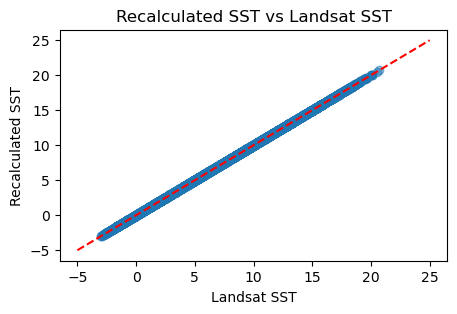

In [3]:
### Recalculate SST using main algorithm ########
df_filtered['recalculated_SST'] = df_filtered['A_coeff']*(df_filtered['Tb']/df_filtered['emissivity']) + df_filtered['B_coeff']*(1/df_filtered['emissivity']) + df_filtered['C_coeff']

# plot recalculated SST vs landsat SST
plt.figure(figsize=(5, 3))
plt.scatter(df_filtered['landsat_SST'], df_filtered['recalculated_SST']-273.15, alpha=0.5)
plt.plot([-5, 25], [-5, 25], color='red', linestyle='--')
plt.xlabel('Landsat SST')
plt.ylabel('Recalculated SST')
plt.title('Recalculated SST vs Landsat SST')
plt.show()


# 1. Sensitivity analysis of EMISSIVITY

Emissivity of sea water for thermal infrared wavelengths ranges from ~0.99 to 0.96. Figure below from: Vincent. (2019). The Case for a Single Channel Composite Arctic Sea Surface Temperature Algorithm. Remote Sensing. 11. 10.3390/rs11202393. 

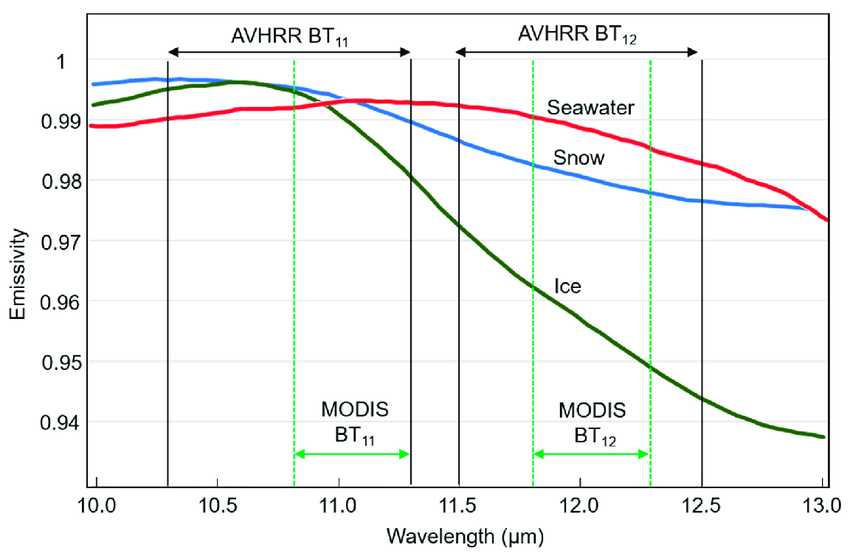 


### Plot uncoreected in-situ vs Landsat SST with original emissivity value:

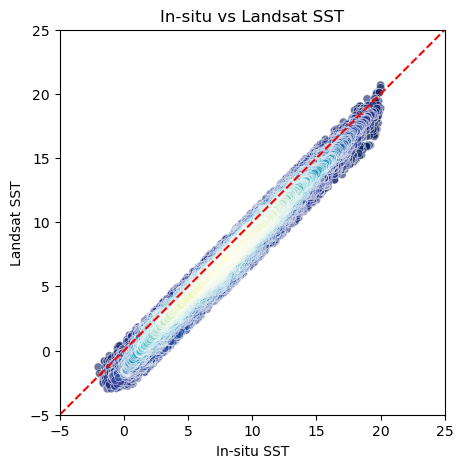

In [4]:
plt.figure(figsize=(8, 5))

# remove nans
df_filtered = df_filtered.dropna(subset=['insitu_SST', 'landsat_SST'])
values = np.vstack([df_filtered['insitu_SST'], df_filtered['landsat_SST']])
kernel = stats.gaussian_kde(values)(values)
df_filtered['density'] = kernel
df_filtered = df_filtered.sort_values(by='density')

sns.scatterplot(data=df_filtered, x='insitu_SST', y='landsat_SST',
                hue='density', palette='YlGnBu_r', alpha=0.6, legend=False)
plt.plot([-5, 25], [-5, 25], color='red', linestyle='--')
plt.xlabel('In-situ SST')
plt.ylabel('Landsat SST')
plt.title('In-situ vs Landsat SST')
plt.xlim(-5, 25)
plt.ylim(-5, 25)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

The optimal emissivity value is 0.97 with an RMSE of 0.93 °C.


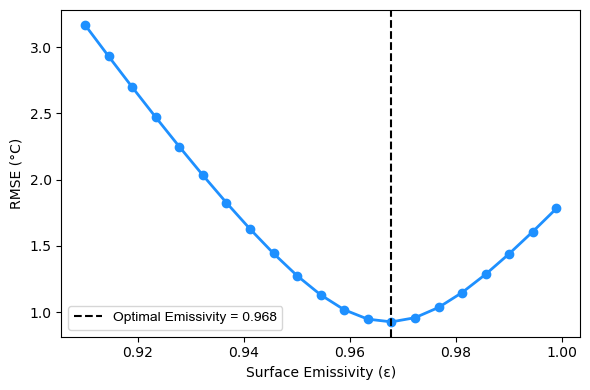

In [5]:
import numpy as np
import matplotlib.pyplot as plt


emissivity_values = np.linspace(0.91, 0.999, num=21)  # Range of emissivity values to test

# Dictionary to store RMSE for each emissivity
errors = {}

for emissivity in emissivity_values:
    recalculated_SST = (df_filtered['A_coeff'] * (df_filtered['Tb'] / emissivity) +
                        df_filtered['B_coeff'] * (1 / emissivity) +
                        df_filtered['C_coeff'])
    
    # convert recalculated SST to Celsius
    recalculated_SST = recalculated_SST - 273.15

    # Calculate RMSE between recalculated SST and in-situ SST
    rmse = np.sqrt(np.nanmean((recalculated_SST - df_filtered['insitu_SST'])**2))
    errors[emissivity] = rmse

# Find the emissivity value with the minimum RMSE
optimal_emissivity = min(errors, key=errors.get)
optimal_rmse = errors[optimal_emissivity]

# Plotting the RMSE for each emissivity value
fig, ax = plt.subplots(figsize=(6, 4))
# set font to Arial and size to 12
plt.rcParams['font.family'] = 'Arial'
ax.plot(errors.keys(), errors.values(), marker='o', linestyle='-', color='dodgerblue', linewidth=2, markersize=6)
ax.set_xlabel('Surface Emissivity (ε)')
ax.set_ylabel('RMSE (°C)')
ax.axvline(x=optimal_emissivity, color='k', linestyle='--', label=f'Optimal Emissivity = {optimal_emissivity:.3f}')
ax.legend()
# save figure
plt.tight_layout()
plt.savefig('optimal_emissivity_rmse_plot.png', dpi=300)

print(f"The optimal emissivity value is {optimal_emissivity:.2f} with an RMSE of {optimal_rmse:.2f} °C.")

##############  # Recalculate SST using optimal emissivity ########
df_filtered['recalculated_SST'] =  df_filtered['A_coeff']*(df_filtered['Tb']/optimal_emissivity) + df_filtered['B_coeff']*(1/optimal_emissivity) + df_filtered['C_coeff']
df_filtered['recalculated_SST'] = df_filtered['recalculated_SST'] - 273.15


# Plot recalculated SST with emissivity of 0.96 vs with 0.99

<Figure size 1000x1000 with 0 Axes>

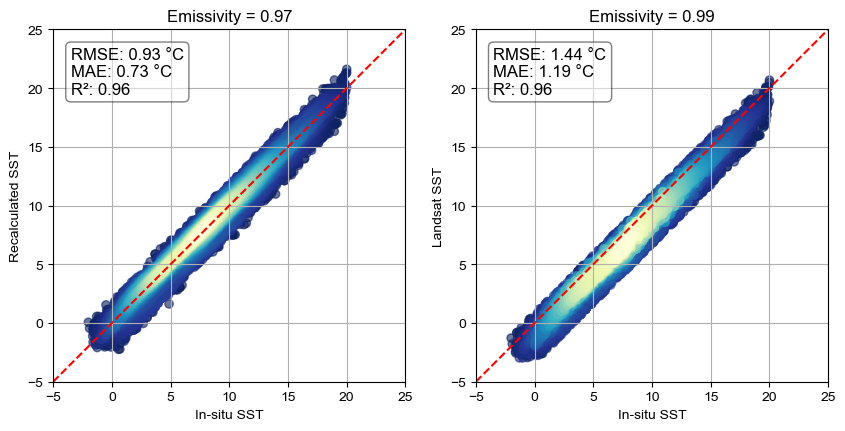

In [6]:
# SCATTER PLOT OF INSITU VS LANDSAT SST
plt.figure(figsize=(10, 10))

# remove nans
df_filtered = df_filtered.dropna(subset=['insitu_SST', 'recalculated_SST'])
values = np.vstack([df_filtered['insitu_SST'], df_filtered['recalculated_SST']])
kernel = stats.gaussian_kde(values)(values)
df_filtered['density'] = kernel
df_filtered = df_filtered.sort_values(by='density')

# create a 2 by 1 subplot of insitu vs recalculated SST and insitu vs landsat SST and showing the density of points
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)
axs[0].scatter(df_filtered['insitu_SST'], df_filtered['recalculated_SST'],
                c=df_filtered['density'], cmap='YlGnBu_r', alpha=0.6)
axs[0].plot([-5, 25], [-5, 25], color='red', linestyle='--')
axs[0].set_xlabel('In-situ SST')
axs[0].set_ylabel('Recalculated SST')
axs[0].set_title('Emissivity = 0.97')
axs[0].set_xlim(-5, 25)
axs[0].set_ylim(-5, 25)
axs[0].set_aspect('equal', adjustable='box')
axs[0].grid(True)
# add text box of stats of rmse, mae and r2 
rmse = np.sqrt(np.nanmean((df_filtered['recalculated_SST'] - df_filtered['insitu_SST'])**2))
mae = np.nanmean(np.abs(df_filtered['recalculated_SST'] - df_filtered['insitu_SST']))
r2 = stats.pearsonr(df_filtered['recalculated_SST'], df_filtered['insitu_SST'])[0]**2
stats_text = f'RMSE: {rmse:.2f} °C\nMAE: {mae:.2f} °C\nR²: {r2:.2f}'
axs[0].text(0.05, 0.95, stats_text,
        transform=axs[0].transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# SCATTER PLOT OF INSITU VS LANDSAT SST
axs[1].scatter(df_filtered['insitu_SST'], df_filtered['landsat_SST'],
                c=df_filtered['density'], cmap='YlGnBu_r', alpha=0.6)
axs[1].plot([-5, 25], [-5, 25], color='red', linestyle='--')
axs[1].set_xlabel('In-situ SST')
axs[1].set_ylabel('Landsat SST')
axs[1].set_title('Emissivity = 0.99')
axs[1].set_xlim(-5, 25)
axs[1].set_ylim(-5, 25)
axs[1].set_aspect('equal', adjustable='box')
axs[1].grid(True)
# add text box of stats
rmse = np.sqrt(np.nanmean((df_filtered['landsat_SST'] - df_filtered['insitu_SST'])**2))
mae = np.nanmean(np.abs(df_filtered['landsat_SST'] - df_filtered['insitu_SST']))
r2 = stats.pearsonr(df_filtered['landsat_SST'], df_filtered['insitu_SST'])[0]**2
stats_text = f'RMSE: {rmse:.2f} °C\nMAE: {mae:.2f} °C\nR²: {r2:.2f}'
axs[1].text(0.05, 0.95, stats_text,
        transform=axs[1].transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.show()

## Calculate optimal adjustment coefficients (D_i) to add the Landsat SST for each sensor

In [7]:
# ndrop NaN values
df_filtered = df_filtered.dropna(subset=['landsat_SST', 'insitu_SST', 'recalculated_SST'])

# USE SCIPY OPTIMISE TO FIND THE OPTIMAL CONSTANT TO ADD TO EACH LANDSAT SENSOR SST VALUE TO MINIMISE THE DIFFERENCE BETWEEN LANDSAT AND INSITU SST
from scipy.optimize import minimize

# Define the error function to minimize
def error_function(constant, landsat_sst, insitu_sst):
    return np.mean(np.abs((landsat_sst + constant) - insitu_sst)) # Mean Absolute Error (MAE)

# Find the optimal constant for each Landsat sensor
optimal_constants = {}
for sensor in df_filtered['Landsat'].unique():
    df_sensor = df_filtered[df_filtered['Landsat'] == sensor]
    result = minimize(error_function, x0=[0], args=(df_sensor['recalculated_SST'], df_sensor['insitu_SST']))
    optimal_constants[sensor] = result.x[0]

# Display the optimal constants for each Landsat sensor
for sensor, constant in optimal_constants.items():
    print(f"Landsat {sensor}: Optimal Constant = {constant:.4f}")

# Apply the optimal constants to adjust the Landsat SST values
df_filtered['adjusted_landsat_SST'] = df_filtered['recalculated_SST'] + df_filtered['Landsat'].map(optimal_constants)

# Calculate the RMSE between the adjusted Landsat SST and in-situ SST
rmse = np.sqrt(np.mean((df_filtered['adjusted_landsat_SST'] - df_filtered['insitu_SST'])**2))
print(f"RMSE after adjustment: {rmse:.2f} °C")


# adjust df original to use the optimal emissivity and add adjusted landsat SST to df_original
df_original['adjusted_landsat_SST'] = df_original['A_coeff']*(df_original['Tb']/optimal_emissivity) + df_original['B_coeff']*(1/optimal_emissivity) + df_original['C_coeff'] 
df_original['adjusted_landsat_SST'] = df_original['adjusted_landsat_SST'] - 273.15
df_original['adjusted_landsat_SST'] = df_original['adjusted_landsat_SST'] + df_original['Landsat'].map(optimal_constants)

# add landsat 4 as the same emissivity and constant as landsat 5 to optimal_constants
optimal_constants['04'] = optimal_constants['05']

# save optimal constants and emissivity to a csv file
df_constants = pd.DataFrame.from_dict(optimal_constants, orient='index', columns=['optimal_constant'])
df_constants['optimal_emissivity'] = optimal_emissivity
df_constants.to_csv('Landsat_SST_optimal_constants.csv', index=True)


Landsat 08: Optimal Constant = -0.0269
Landsat 09: Optimal Constant = -0.1123
Landsat 07: Optimal Constant = -0.0668
Landsat 05: Optimal Constant = 0.1548
RMSE after adjustment: 0.93 °C


# Validation scatter graphs

C:\Users\s1834371\AppData\Local\Temp\ipykernel_17600\1354602052.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor['density'] = kernel


Sensor: 09, Median Error: 0.57 °C, Precision: 0.91 °C, RMSE: 0.92 °C, SD of Errors: 0.91 °C


C:\Users\s1834371\AppData\Local\Temp\ipykernel_17600\1354602052.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor['density'] = kernel


Sensor: 08, Median Error: 0.57 °C, Precision: 0.92 °C, RMSE: 0.93 °C, SD of Errors: 0.92 °C


C:\Users\s1834371\AppData\Local\Temp\ipykernel_17600\1354602052.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor['density'] = kernel
C:\Users\s1834371\AppData\Local\Temp\ipykernel_17600\1354602052.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor['density'] = kernel


Sensor: 07, Median Error: 0.60 °C, Precision: 0.93 °C, RMSE: 0.94 °C, SD of Errors: 0.93 °C
Sensor: 05, Median Error: 0.54 °C, Precision: 0.85 °C, RMSE: 0.85 °C, SD of Errors: 0.85 °C


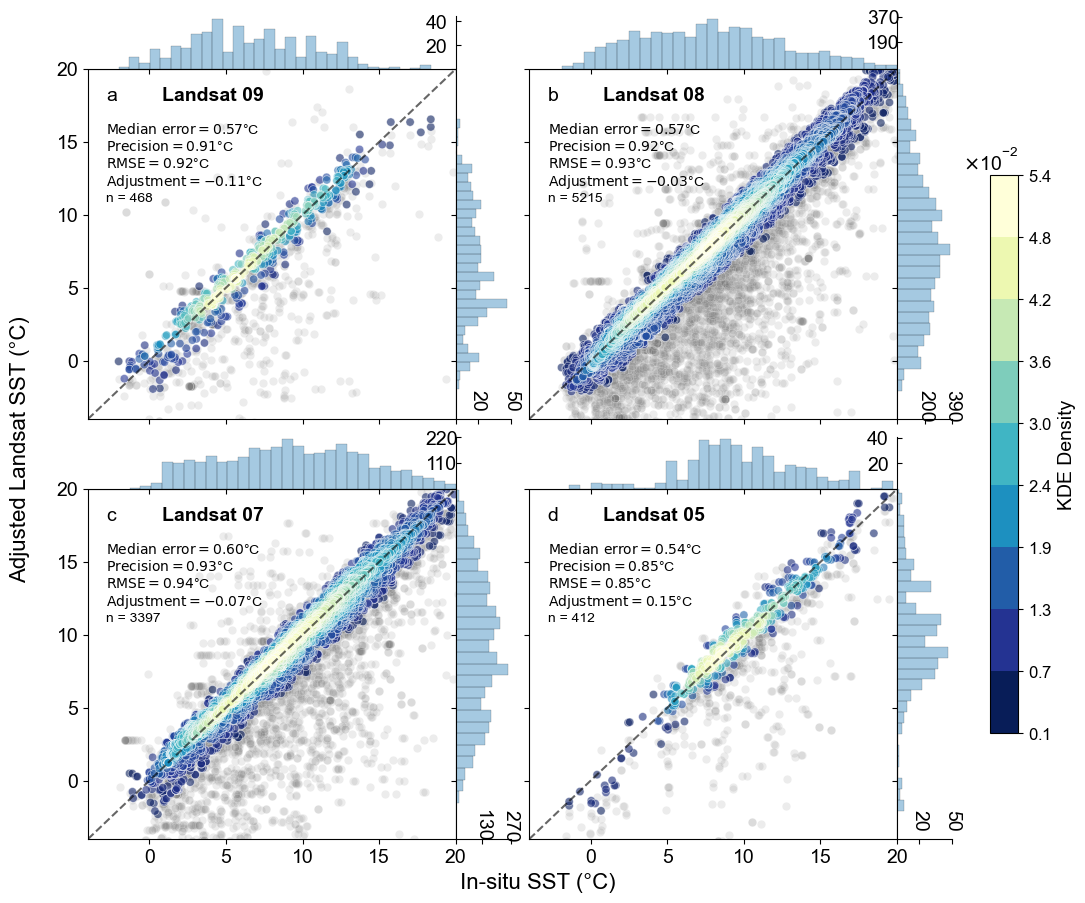

In [19]:
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

# set font to arail
plt.rcParams['font.family'] = 'Arial'

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()

sensors = df_filtered['Landsat'].unique()
sensors = np.sort(sensors)[::-1]

for i, sensor in enumerate(sensors):
    ax = axes[i]
    df_sensor = df_filtered[df_filtered['Landsat'] == sensor]
    df_sensor_original = df_original[df_original['Landsat'] == sensor]

    # Calculate density
    values = np.vstack([df_sensor['adjusted_landsat_SST'], df_sensor['insitu_SST']])
    kernel = stats.gaussian_kde(values)(values)
    df_sensor['density'] = kernel
    df_sensor = df_sensor.sort_values(by='density')

    sns.scatterplot(data=df_sensor_original, x='insitu_SST', y='landsat_SST', color='grey', alpha=0.15, ax=ax, legend=False)
    # Scatter plot with KDE-based coloring
    sns.scatterplot(data=df_sensor, x='insitu_SST', y='adjusted_landsat_SST',
                    hue='density', palette='YlGnBu_r', alpha=0.6, ax=ax, legend=False)

    ax.set_xlim(-4, 20)
    ax.set_ylim(-4, 20)
    ax.set_ylabel('')
    ax.set_xlabel('')


    # Marginal histograms
    ax_histx = ax.inset_axes([0, 1, 1, 0.15], sharex=ax)
    ax_histy = ax.inset_axes([1, 0, 0.15, 1], sharey=ax)

    ax_histx.hist(df_sensor['insitu_SST'], bins=30, color='#1f78b4', alpha=0.4, edgecolor='k', linewidth=0.3)
    ax_histy.hist(df_sensor['adjusted_landsat_SST'], bins=30, color='#1f78b4', alpha=0.4, orientation='horizontal', edgecolor='k', linewidth=0.3)

    ax_histx.tick_params(axis='x', labelbottom=False)

    ax_histx.tick_params(axis='y', labelleft=True)
    # put y scale on the right side of the plot
    ax_histx.yaxis.tick_right()
    ax_histx.yaxis.set_label_position('right')
    # set y ticks to have the max value of the histogram and 1/2 of the max value of the histogram
    max_val = int(round(ax_histx.get_ylim()[1], -1))
    half_val = int(round(0.5 * ax_histx.get_ylim()[1], -1))
    ax_histx.set_yticks([half_val, max_val])
    ax_histx.set_yticklabels([half_val, max_val])
    ax_histx.yaxis.set_tick_params(pad=-25)


    ax_histy.tick_params(axis='x', labelbottom=True)
    ax_histy.tick_params(axis='y', labelleft=False)

    ax_histx.spines['top'].set_visible(False)
    ax_histx.spines['right'].set_visible(True)
    ax_histx.spines['left'].set_visible(False)
    ax_histy.spines['top'].set_visible(False)
    ax_histy.spines['right'].set_visible(False)
    ax_histy.spines['bottom'].set_visible(True)

    # set x ticks to have the max value of the histogram and 1/2 of the max value of the histogram
    max_val = int(round(ax_histy.get_xlim()[1], -1))
    half_val = int(round(0.5 * ax_histy.get_xlim()[1], -1))
    ax_histy.set_xticks([half_val, max_val])
    ax_histy.set_xticklabels([half_val, max_val])
    # rotate x ticks
    ax_histy.tick_params(axis='x', rotation=-90)
    # move tick labels to the left side of the spine by moving text upwards
    ax_histy.xaxis.set_tick_params(pad=-25) 

    # Title and axis labels
    # ax.set_title(f'Landsat {sensor}', fontsize=14, fontweight='bold', loc='left', pad=0.1)
    ax.text(0.05, 0.95, f'{chr(97 + i)}', transform=ax.transAxes, fontsize=14, verticalalignment='top')
    ax.text(0.2, 0.95, f'Landsat {sensor}', transform=ax.transAxes, fontsize=14, verticalalignment='top', fontweight='bold')

    # Add y=x line
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.plot(lims, lims, 'k--', alpha=0.6, zorder=5)

    # Calculate statistics
    median_err = np.median(np.abs(df_sensor['adjusted_landsat_SST'] - df_sensor['insitu_SST']))
    # precision = np.median(np.abs((df_sensor['adjusted_landsat_SST'] - df_sensor['insitu_SST']) - median_err))
    precision = np.std(df_sensor['adjusted_landsat_SST'] - df_sensor['insitu_SST'])
    RMSE = np.sqrt(mean_squared_error(df_sensor['insitu_SST'], df_sensor['adjusted_landsat_SST']))
    # calculate the SD Of errors
    SD_err = np.std(df_sensor['adjusted_landsat_SST'] - df_sensor['insitu_SST'])
    print(f"Sensor: {sensor}, Median Error: {median_err:.2f} °C, Precision: {precision:.2f} °C, RMSE: {RMSE:.2f} °C, SD of Errors: {SD_err:.2f} °C")

    optimal_constant = optimal_constants[sensor]
    n = len(df_sensor)

    # Statistics text box
    textstr = '\n'.join((
        r'$\mathrm{Median\ error}=%.2f$°C' % (median_err,),
        r'$\mathrm{Precision}=%.2f$°C' % (precision,),
        r'$\mathrm{RMSE}=%.2f$°C' % (RMSE,),
        r'$\mathrm{Adjustment}=%.2f$°C' % (optimal_constant,),
        r'n = %d' % (n,)
    ))

    # props = dict(boxstyle='round', facecolor='white', alpha=0.9)
    ax.text(0.05, 0.85, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top')#, bbox=props)

# Normalize colorbar for all subplots
# norm = plt.Normalize(vmin=df_sensor['density'].min(), vmax=df_sensor['density'].max())
# sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
# sm.set_array([])
# cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.05, pad=0.1)
# cbar.set_label('KDE Density', fontsize=14)



# Define discrete intervals for the colorbar
bounds = np.linspace(df_sensor['density'].min(), df_sensor['density'].max(), 10)
norm = mcolors.BoundaryNorm(bounds, ncolors=256)

sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.03, pad=0.1)
cbar.set_label('KDE Density', fontsize=14)



# Increase font size of tick labels
cbar.ax.tick_params(labelsize=12)
cbar.ax.yaxis.set_major_formatter(OOMFormatter(-2, "%1.1f"))#mticker.ScalarFormatter(useMathText=True))
# cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.1e}'))

# Set shared axis labels
fig.text(0.5, 0.06, 'In-situ SST (°C)', ha='center', fontsize=16)
fig.text(0.06, 0.5, 'Adjusted Landsat SST (°C)', va='center', rotation='vertical', fontsize=16)

# save figure

fig.savefig('figures/validation_scatter_subplots.png', dpi=600, bbox_inches='tight')
# plt.tight_layout(pad=3.0)
plt.show()

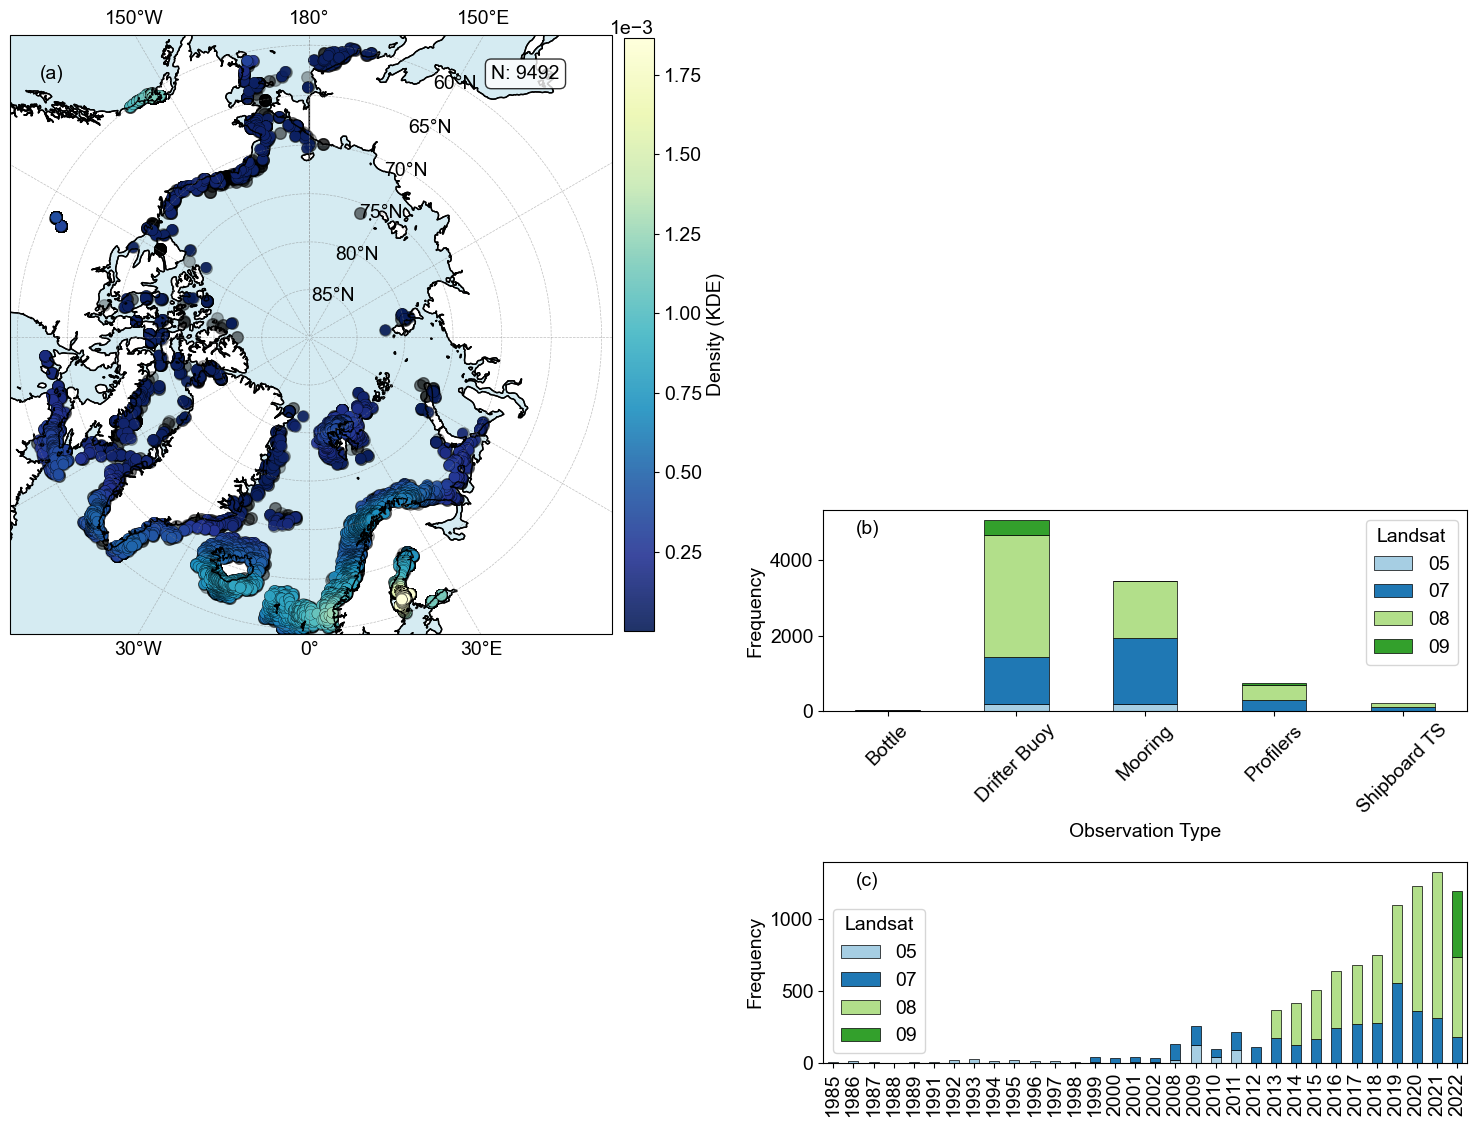

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.ticker as mticker
# Set the style for seaborn

df = df_filtered.copy()
original_df = df_original.copy()

# remove any NaN values
df = df.dropna(subset=['lon', 'lat'])
df = df.dropna(subset=['recalculated_SST', 'insitu_SST'])
original_df = original_df.dropna(subset=['lon', 'lat'])

# data prep lon and lat to float 2 decimal places
df['lon'] = df['lon'].astype(float).round(2)
df['lat'] = df['lat'].astype(float).round(2)
original_df['lon'] = original_df['lon'].astype(float).round(2)
original_df['lat'] = original_df['lat'].astype(float).round(2)


# Calculate the kernel density estimate for spatial points
values = np.vstack([df['lon'], df['lat']])
# convert to int
kernel = stats.gaussian_kde(values)(values)
#sort the points by density
df['density'] = kernel
df = df.sort_values(by='density')


# rename elements in the OBS_ID column (e.g. if the OBS_ID is 'DR' rename it Drifter Buoy, if it is 'CT' rename it CTD, etc.)
df['OBS_ID'] = df['OBS_ID'].replace({'DR': 'Drifter Buoy', 'CT': 'CTD', 'BT' : 'Bottle', 'MO' : 'Mooring', 'PF' : 'Profilers', 'TS' : 'Shipboard TS'})
obs_sensor_counts = df.groupby(['OBS_ID', 'Landsat']).size().unstack(fill_value=0)

# Setup the figure and gridspec with height ratios
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1])  # More space for the map

# set gony to arisl                     
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14

# First plot: Map (left side, spans 2 rows)
ax0 = fig.add_subplot(gs[0:2, 0], projection=ccrs.NorthPolarStereo())
ax0.set_extent([-180, 180, 59, 90], ccrs.PlateCarree())


# add ocean
ax0.add_feature(cfeature.OCEAN, zorder=0, facecolor='lightblue', alpha=0.5)
# Add geographic features
land = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor='w')
ax0.add_feature(land, zorder=0)
ax0.coastlines()

# Plotting data on the map
# Scatter plot of the original dataset with unfiltered values (slightly transparent)
ax0.scatter(original_df['lon'], original_df['lat'], color='k', s=70, transform=ccrs.PlateCarree(), alpha=0.3, label='Unfiltered Data')

# Scatter plot of the filtered dataset
sc = ax0.scatter(df['lon'], df['lat'], c=df['density'], cmap='YlGnBu_r', s=60, transform=ccrs.PlateCarree(), alpha=0.9, edgecolor='k', linewidth=0.2, label='Filtered Data')
# format colorbar ticks to scientific notation
norm = mcolors.Normalize(vmin=df['density'].min(), vmax=df['density'].max())
sc.set_norm(norm)
# Add a colorbar
# Use a colorbar with a label


cb = fig.colorbar(sc, ax=ax0, orientation='vertical', fraction=0.046, pad=0.02)
cb.formatter.set_powerlimits((0, 0))
# cb.formatter.set_scientific(True)
cb.set_label('Density (KDE)')

# add text box to top left corner of the map with the number of points
total_points = len(df)
textstr = f'N: {total_points}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax0.text(0.8, 0.95, textstr, transform=ax0.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
# add (A) to the top left corner of the plot
ax0.text(0.05, 0.95, '(a)', transform=ax0.transAxes, fontsize=14,
        verticalalignment='top')

# add gridlines and coordinate labels
gl = ax0.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--', rotate_labels=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
gl.ylocator = mticker.FixedLocator(np.arange(60, 91, 5))   
# do not rotate longitude labels


# Second plot: Histogram of obs_id (middle right)
ax1 = fig.add_subplot(gs[1, 1])

# Plotting the OBS_ID histogram
colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c']
cmap = mcolors.ListedColormap(colors)
obs_sensor_counts.plot(kind='bar', stacked=True, ax=ax1, cmap=cmap, edgecolor='black', linewidth=0.5)
ax1.set_ylabel('Frequency')
ax1.legend(title='Landsat')
# add (A) to the top left corner of the plot
ax1.text(0.05, 0.95, '(b)', transform=ax1.transAxes, fontsize=14,
        verticalalignment='top')
# rotate x tick labels
ax1.tick_params(axis='x', rotation=45)
# Set x-axis label
ax1.set_xlabel('Observation Type')

# Third plot: Histogram of years (bottom right)
ax2 = fig.add_subplot(gs[2, 1])


# Plotting the Year histogram
df['Year'] = pd.to_datetime(df['date'], errors='coerce').dt.year

# Create a pivot table to count the number of observations per year and Landsat sensor
pivot_table = df.pivot_table(index='Year', columns='Landsat', values='insitu_SST', aggfunc='count', fill_value=0, )
# make years int
pivot_table.index = pivot_table.index.astype(int)

pivot_table.plot(kind='bar', stacked=True, ax=ax2, cmap=cmap, edgecolor='black', linewidth=0.5)
ax2.set_ylabel('Frequency')
ax2.set_xlabel('')
ax2.text(0.05, 0.95, '(c)', transform=ax2.transAxes, fontsize=14,
        verticalalignment='top')

plt.tight_layout()
plt.savefig('figures/validation_location_histograms.png', dpi=300, bbox_inches='tight')
plt.show()


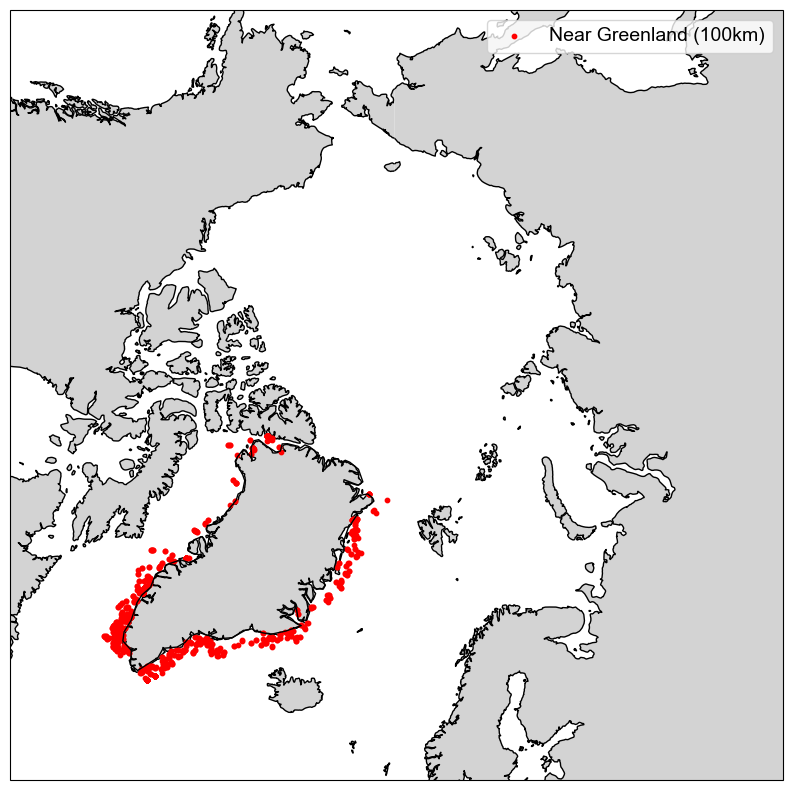

In [10]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 1. Load and prepare Greenland data (already in EPSG:4326)
world = gpd.read_file(r'C:\Users\s1834371\Downloads\ne_110m_admin_0_countries.zip')
world = world.rename(columns={'ADMIN': 'name'})
greenland = world[world['name'] == 'Greenland'].copy()

# 2. Create point GeoDataFrame (ensure CRS matches)
geometry = [Point(lon, lat) for lon, lat in zip(df_filtered['lon'], df_filtered['lat'])]
gdf = gpd.GeoDataFrame(df_filtered, geometry=geometry, crs="EPSG:4326")

# 3. Convert both to a METER-BASED CRS for distance operations
target_crs = "EPSG:3413"  # NSIDC Polar Stereographic North (meters, Arctic-optimized)
greenland_proj = greenland.to_crs(target_crs)
gdf_proj = gdf.to_crs(target_crs)

# 4. Perform spatial join with 100km buffer
gdf_greenland = gpd.sjoin_nearest(
    gdf_proj, 
    greenland_proj, 
    how='inner', 
    max_distance=200000,  # 100 km in meters
    distance_col="distance"
)

# 5. Plotting (convert back to EPSG:4326 for visualization)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.set_extent([-180, 180, 59, 90], ccrs.PlateCarree())

# Add base features
ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE, zorder=1, edgecolor='black')

# Plot Greenland and points (using original lat/lon)
ax.add_geometries(
    greenland.geometry, 
    ccrs.PlateCarree(), 
    facecolor='none', 
    edgecolor='black', 
    linewidth=1, 
    zorder=2
)

# Convert joined points back to lat/lon for plotting
gdf_greenland_plot = gdf_greenland.to_crs("EPSG:4326")
ax.scatter(
    gdf_greenland_plot.geometry.x,  # lon
    gdf_greenland_plot.geometry.y,   # lat
    c='red', 
    s=10, 
    transform=ccrs.PlateCarree(), 
    label='Near Greenland (100km)'
)

plt.legend()
plt.show()


In [11]:
gdf_greenland

,date,lat,lon,insitu_SST,landsat_SST,Landsat,tile_id,A_coeff,B_coeff,C_coeff,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,distance
3167,2022-07-08T20:00:00,77.13761,-13.204269999999998,1.050,-2.158673,08,LC08_L1TP_050239_20220708_20220721_02_T1,1.128200,-279.421200,244.077200,...,None,None,None,None,None,None,None,None,None,130430.391943
3126,2022-07-05T22:00:00,77.1339,-17.4337,0.689,-2.389063,09,LC09_L1TP_053239_20220705_20230408_02_T1,1.126700,-279.168500,244.237900,...,None,None,None,None,None,None,None,None,None,29645.320403
1481,2021-06-14T13:00:00,77.1623,-12.218700000000002,-0.610,-2.941489,08,LC08_L1TP_232005_20210614_20210622_02_T1,1.009000,-232.275000,230.569800,...,None,None,None,None,None,None,None,None,None,154608.134494
5197,2018-07-25T17:00:00,77.8518,-70.07,5.800,6.401107,08,LC08_L1TP_038004_20180725_20200831_02_T1,0.997071,-222.991659,224.287857,...,None,None,None,None,None,None,None,None,None,0.000000
2661,2022-05-01T14:00:00,65.46865000000001,-35.07108999999999,-1.630,-2.442225,09,LC09_L1TP_231014_20220501_20230418_02_T1,0.975100,-206.218700,213.052600,...,None,None,None,None,None,None,None,None,None,82505.116758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780,2020-08-13T15:00:00,65.25409,-53.81317,6.850,5.967502,08,LC08_L1TP_008014_20200813_20200919_02_T1,1.043011,-248.050620,236.893079,...,None,None,None,None,None,None,None,None,None,57450.392627
5762,2019-07-28T15:00:00,62.21240000000001,-52.993,7.940,7.097660,08,LC08_L1TP_006016_20190728_20200827_02_T1,1.090623,-266.121394,241.479603,...,None,None,None,None,None,None,None,None,None,149062.166184
5761,2019-07-28T14:00:00,62.217000000000006,-53.02,7.920,7.132544,08,LC08_L1TP_006016_20190728_20200827_02_T1,1.092625,-266.829749,241.617952,...,None,None,None,None,None,None,None,None,None,149952.774573
1730,2021-08-01T15:00:00,64.2302,-38.45550000000001,7.450,6.701626,08,LC08_L1TP_232015_20210801_20210810_02_T1,1.054100,-253.194300,238.954800,...,None,None,None,None,None,None,None,None,None,110175.982961


c:\Users\s1834371\AppData\Local\miniconda3\envs\c3_winterslowdown\Lib\site-packages\geopandas\geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\s1834371\AppData\Local\miniconda3\envs\c3_winterslowdown\Lib\site-packages\geopandas\geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\s1834371\AppData\Local\miniconda3\envs\c3_winterslowdown\Lib\site-packages\geopandas\geodataframe.py:1981: SettingW

Y-axis limits: (np.float64(0.0), np.float64(25.2))
Max value: 25, Half value: 12
Y-axis limits: (np.float64(0.0), np.float64(84.0))
Max value: 84, Half value: 42
Y-axis limits: (np.float64(0.0), np.float64(4.2))
Max value: 4, Half value: 2


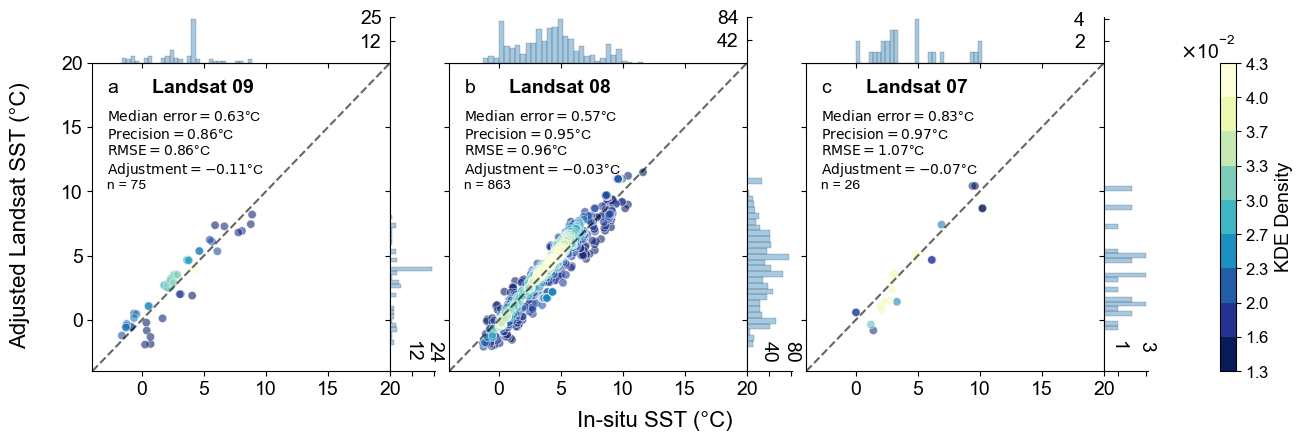

In [20]:
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

# set font to arail
plt.rcParams['font.family'] = 'Arial'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=True, sharey=True)
axes = axes.flatten()

sensors = df_filtered['Landsat'].unique()
sensors = np.sort(sensors)[::-1]
# remove last sensor (landsat 5) from the list of sensors
sensors = sensors[:-1]

for i, sensor in enumerate(sensors):
    ax = axes[i]
    df_sensor = gdf_greenland[gdf_greenland['Landsat'] == sensor]

    # Calculate density
    values = np.vstack([df_sensor['adjusted_landsat_SST'], df_sensor['insitu_SST']])
    kernel = stats.gaussian_kde(values)(values)
    df_sensor['density'] = kernel
    df_sensor = df_sensor.sort_values(by='density')

    # Scatter plot with KDE-based coloring
    sns.scatterplot(data=df_sensor, x='insitu_SST', y='adjusted_landsat_SST',
                    hue='density', palette='YlGnBu_r', alpha=0.6, ax=ax, legend=False)

    ax.set_xlim(-4, 20)
    ax.set_ylim(-4, 20)
    ax.set_ylabel('')
    ax.set_xlabel('')


    # Marginal histograms
    ax_histx = ax.inset_axes([0, 1, 1, 0.15], sharex=ax)
    ax_histy = ax.inset_axes([1, 0, 0.15, 1], sharey=ax)

    ax_histx.hist(df_sensor['insitu_SST'], bins=30, color='#1f78b4', alpha=0.4, edgecolor='k', linewidth=0.3)
    ax_histy.hist(df_sensor['adjusted_landsat_SST'], bins=30, color='#1f78b4', alpha=0.4, orientation='horizontal', edgecolor='k', linewidth=0.3)

    ax_histx.tick_params(axis='x', labelbottom=False)

    ax_histx.tick_params(axis='y', labelleft=True)
    # put y scale on the right side of the plot
    ax_histx.yaxis.tick_right()
    ax_histx.yaxis.set_label_position('right')
    # set y ticks to have the max value of the histogram and 1/2 of the max value of the histogram
    # print y axis limits
    print(f"Y-axis limits: {ax_histx.get_ylim()}")
    max_val = int(round(ax_histx.get_ylim()[1], 1))
    half_val = int(round(0.5 * ax_histx.get_ylim()[1], 1))
    print(f"Max value: {max_val}, Half value: {half_val}")

    ax_histx.set_yticks([half_val, max_val])
    ax_histx.set_yticklabels([half_val, max_val])
    ax_histx.yaxis.set_tick_params(pad=-25)


    ax_histy.tick_params(axis='x', labelbottom=True)
    ax_histy.tick_params(axis='y', labelleft=False)

    ax_histx.spines['top'].set_visible(False)
    ax_histx.spines['right'].set_visible(True)
    ax_histx.spines['left'].set_visible(False)
    ax_histy.spines['top'].set_visible(False)
    ax_histy.spines['right'].set_visible(False)
    ax_histy.spines['bottom'].set_visible(True)

    # set x ticks to have the max value of the histogram and 1/2 of the max value of the histogram
    max_val = int(round(ax_histy.get_xlim()[1], 1))
    half_val = int(round(0.5 * ax_histy.get_xlim()[1], 1))
    ax_histy.set_xticks([half_val, max_val])
    ax_histy.set_xticklabels([half_val, max_val])
    # rotate x ticks
    ax_histy.tick_params(axis='x', rotation=-90)
    # move tick labels to the left side of the spine by moving text upwards
    ax_histy.xaxis.set_tick_params(pad=-25) 

    # Title and axis labels
    # ax.set_title(f'Landsat {sensor}', fontsize=14, fontweight='bold', loc='left', pad=0.1)
    ax.text(0.05, 0.95, f'{chr(97 + i)}', transform=ax.transAxes, fontsize=14, verticalalignment='top')
    ax.text(0.2, 0.95, f'Landsat {sensor}', transform=ax.transAxes, fontsize=14, verticalalignment='top', fontweight='bold')

    # Add y=x line
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.plot(lims, lims, 'k--', alpha=0.6, zorder=5)

    # Calculate statistics
    median_err = np.median(np.abs(df_sensor['adjusted_landsat_SST'] - df_sensor['insitu_SST']))
    # precision = np.median(np.abs((df_sensor['adjusted_landsat_SST'] - df_sensor['insitu_SST']) - median_err))
    precision = np.std(df_sensor['adjusted_landsat_SST'] - df_sensor['insitu_SST'])
    RMSE = np.sqrt(mean_squared_error(df_sensor['insitu_SST'], df_sensor['adjusted_landsat_SST']))
    optimal_constant = optimal_constants[sensor]
    n = len(df_sensor)

    # Statistics text box
    textstr = '\n'.join((
        r'$\mathrm{Median\ error}=%.2f$°C' % (median_err,),
        r'$\mathrm{Precision}=%.2f$°C' % (precision,),
        r'$\mathrm{RMSE}=%.2f$°C' % (RMSE,),
        r'$\mathrm{Adjustment}=%.2f$°C' % (optimal_constant,),
        r'n = %d' % (n,)
    ))

    # props = dict(boxstyle='round', facecolor='white', alpha=0.9)
    ax.text(0.05, 0.85, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top')#, bbox=props)

# Normalize colorbar for all subplots
# norm = plt.Normalize(vmin=df_sensor['density'].min(), vmax=df_sensor['density'].max())
# sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
# sm.set_array([])
# cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.05, pad=0.1)
# cbar.set_label('KDE Density', fontsize=14)



# Define discrete intervals for the colorbar
bounds = np.linspace(df_sensor['density'].min(), df_sensor['density'].max(), 10)
norm = mcolors.BoundaryNorm(bounds, ncolors=256)

sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.03, pad=0.1)
cbar.set_label('KDE Density', fontsize=14)



# Increase font size of tick labels
cbar.ax.tick_params(labelsize=12)
cbar.ax.yaxis.set_major_formatter(OOMFormatter(-2, "%1.1f"))#mticker.ScalarFormatter(useMathText=True))
# cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.1e}'))

# Set shared axis labels
fig.text(0.5, -0.03, 'In-situ SST (°C)', ha='center', fontsize=16)
fig.text(0.07, 0.5, 'Adjusted Landsat SST (°C)', va='center', rotation='vertical', fontsize=16)

# save figure

plt.savefig('validation_scatter_subplots.png', dpi=600, bbox_inches='tight')
# plt.tight_layout(pad=3.0)
plt.show()